## Keras Sequantial Model

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow_core.estimator import inputs
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

from tensorflow.keras.models import load_model
from keras.utils import to_categorical

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import math

import pathlib
import shutil
import tempfile


### Define functions

In [68]:
def encode(i):
    switcher = {
        "H": 2,
        "D": 1,
        "A": 0,
        }
    # 1 be assigned as default value of passed argument (if goals > 5)
    return switcher.get(i, 1)

def normalize_and_encode(dataframe):
    column_names_to_not_normalize = ['result']
    column_names_to_normalize = [x for x in list(dataframe) if x not in column_names_to_not_normalize ]
    x = dataframe[column_names_to_normalize].values
    #x_scaled = preprocessing.normalize(x) vom alten
    std_scale = preprocessing.MinMaxScaler().fit(x)
    x_train_norm = std_scale.transform(x)
    df_temp = pd.DataFrame(x_train_norm, columns=column_names_to_normalize, index = dataframe.index)
    dataframe[column_names_to_normalize] = df_temp

    #dataframe['result'] = dataframe.apply(lambda row: encode(row['result']), axis=1)

    le = preprocessing.LabelEncoder()
    le.fit([ "H", "D", "A"])
    dataframe.loc[:,['result']]=le.transform(dataframe['result'])
    
    return dataframe

def get_X_and_y(dataframe):
    X = dataframe.drop(columns=['result']).values
    y = dataframe[['result']].values
    return X,y


#def get_lr_schedule(train, batch_size):
    #lr_schedule = tf.keras.optimizers.SGD(lr=0.001, clipvalue=0.5)
    #tf.keras.optimizers.schedules.InverseTimeDecay(
    #0.0001, # lr??
    #decay_steps=(len(train)//batch_size)*1000,
    #decay_rate=1,
    #staircase=False)
    #return lr_schedule

def get_optimizer(train, batch_size):
    return tf.keras.optimizers.SGD(lr=0.01, momentum=0.9) 
            #tf.keras.optimizers.Adam(get_lr_schedule(train, batch_size))


def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name), # Jupyter Notebook
        #tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1) # Google Colab
      ]

def compile_and_fit(model, name, X, y, validation_split, batch_size, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer(X, batch_size)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()
     
    history = model.fit(
        X,
        y,
        validation_split=validation_split,
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=get_callbacks(name),
        verbose=0)
    
    model.save("../model/%s.h5" %name) 
    
    return history

def plot_history(model_history):
	plt.plot(model_history.history['accuracy'])
	plt.plot(model_history.history['val_accuracy'])
	plt.title("%s accuracy" %model_history)
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	
	plt.plot(model_history.history['loss'])
	plt.plot(model_history.history['val_loss'])
	plt.title("%s loss" %model_history)
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

### Read the sliding window + Preprocessing

In [69]:
df02 = pd.read_csv('../data/data_classification_results/sliding02_shots.csv', sep=',', index_col=0)
df02


,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,H,3.50,3.30,2.10,1,3,6,11,16,137,67,117,53,8,2,0,15,6,161,78,72,30
1,D,2.50,3.30,2.88,3,1,6,8,16,134,64,151,77,3,3,4,11,18,104,44,87,36
2,A,1.91,3.40,4.20,4,2,4,10,15,120,58,124,56,2,2,6,11,15,134,59,100,46
3,H,3.25,3.25,2.30,5,2,3,22,12,177,82,74,37,6,3,1,19,8,169,95,113,58
4,H,1.20,6.00,19.00,7,2,1,15,8,161,72,74,31,3,2,5,10,17,143,69,134,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,H,5.00,3.80,1.70,4,2,4,10,12,80,43,117,60,2,4,4,10,21,119,58,112,65
7029,H,2.00,3.60,3.70,3,2,5,9,21,89,47,92,46,1,4,5,7,21,104,55,63,26
7030,H,1.80,3.75,4.50,3,3,4,8,8,122,59,92,50,5,2,3,15,9,84,43,118,56
7031,H,1.33,5.25,9.00,2,3,5,12,14,124,62,99,50,3,3,4,11,17,103,53,122,54


In [70]:
n02 = normalize_and_encode(df02)


train02, test02 = train_test_split(n02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')


train_X02,train_y02 = get_X_and_y(train02)

test_X02,test_y02 = get_X_and_y(test02)

train_y02 = to_categorical(train_y02)
test_y02 = to_categorical(test_y02)

6329 train examples
704 test examples


In [71]:
n02

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,0.098558,0.121795,0.025551,0.1,0.375,0.6,0.209302,0.516129,0.549020,0.439252,0.444444,0.300971,0.8,0.250,0.000000,0.317073,0.193548,0.692810,0.548077,0.176796,0.074766
1,1,0.058494,0.121795,0.045090,0.3,0.125,0.6,0.139535,0.516129,0.529412,0.411215,0.643275,0.533981,0.3,0.375,0.444444,0.219512,0.580645,0.320261,0.221154,0.259669,0.130841
2,0,0.034856,0.128205,0.078156,0.4,0.250,0.4,0.186047,0.483871,0.437908,0.355140,0.485380,0.330097,0.2,0.250,0.666667,0.219512,0.483871,0.516340,0.365385,0.331492,0.224299
3,2,0.088542,0.118590,0.030561,0.5,0.250,0.3,0.465116,0.387097,0.810458,0.579439,0.192982,0.145631,0.6,0.375,0.111111,0.414634,0.258065,0.745098,0.711538,0.403315,0.336449
4,2,0.006410,0.294872,0.448898,0.7,0.250,0.1,0.302326,0.258065,0.705882,0.485981,0.192982,0.087379,0.3,0.250,0.555556,0.195122,0.548387,0.575163,0.461538,0.519337,0.439252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,0.158654,0.153846,0.015531,0.4,0.250,0.4,0.186047,0.387097,0.176471,0.214953,0.444444,0.368932,0.2,0.500,0.444444,0.195122,0.677419,0.418301,0.355769,0.397790,0.401869
7029,2,0.038462,0.141026,0.065631,0.3,0.250,0.5,0.162791,0.677419,0.235294,0.252336,0.298246,0.233010,0.1,0.500,0.555556,0.121951,0.677419,0.320261,0.326923,0.127072,0.037383
7030,2,0.030449,0.150641,0.085671,0.3,0.375,0.4,0.139535,0.258065,0.450980,0.364486,0.298246,0.271845,0.5,0.250,0.333333,0.317073,0.290323,0.189542,0.211538,0.430939,0.317757
7031,2,0.011619,0.246795,0.198397,0.2,0.375,0.5,0.232558,0.451613,0.464052,0.392523,0.339181,0.271845,0.3,0.375,0.444444,0.219512,0.548387,0.313725,0.307692,0.453039,0.299065


In [72]:
byhomegoal = df02.groupby('result')
byhomegoal.size().sort_values(ascending=False)

result
2    3238
0    2035
1    1760
dtype: int64

In [73]:
fdA = df02[df02.result == 0].head(1760)
fdD = df02[df02.result == 1].head(1760)
fdH = df02[df02.result == 2].head(1760)
df02 = pd.concat([fdA, fdD])
df02 = pd.concat([df02, fdH])

df02

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
2,0,0.034856,0.128205,0.078156,0.4,0.250,0.4,0.186047,0.483871,0.437908,0.355140,0.485380,0.330097,0.2,0.250,0.666667,0.219512,0.483871,0.516340,0.365385,0.331492,0.224299
5,0,0.053686,0.121795,0.048096,0.3,0.375,0.4,0.162791,0.354839,0.320261,0.252336,0.538012,0.533981,0.4,0.250,0.444444,0.219512,0.419355,0.464052,0.365385,0.453039,0.345794
6,0,0.062500,0.118590,0.043086,0.4,0.125,0.5,0.302326,0.516129,0.470588,0.401869,0.654971,0.495146,0.4,0.375,0.333333,0.268293,0.516129,0.313725,0.288462,0.541436,0.504673
7,0,0.048478,0.118590,0.058116,0.5,0.250,0.3,0.302326,0.548387,0.235294,0.158879,0.771930,0.495146,0.2,0.250,0.666667,0.121951,0.387097,0.477124,0.413462,0.596685,0.485981
9,0,0.026442,0.153846,0.098196,0.6,0.250,0.2,0.348837,0.354839,0.274510,0.205607,0.596491,0.495146,0.3,0.250,0.555556,0.170732,0.483871,0.326797,0.288462,0.662983,0.532710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,2,0.026442,0.153846,0.091934,0.3,0.375,0.4,0.302326,0.516129,0.444444,0.411215,0.333333,0.378641,0.3,0.375,0.444444,0.195122,0.387097,0.287582,0.201923,0.397790,0.383178
3749,2,0.053686,0.121795,0.045591,0.4,0.375,0.3,0.116279,0.354839,0.496732,0.439252,0.491228,0.291262,0.5,0.250,0.333333,0.536585,0.548387,0.444444,0.326923,0.491713,0.401869
3750,2,0.030449,0.134615,0.085671,1.0,0.000,0.0,0.488372,0.032258,0.843137,0.588785,0.157895,0.097087,0.5,0.375,0.222222,0.292683,0.354839,0.496732,0.326923,0.331492,0.242991
3751,2,0.018429,0.166667,0.148297,0.6,0.250,0.2,0.325581,0.290323,0.581699,0.523364,0.269006,0.203883,0.1,0.375,0.666667,0.121951,0.516129,0.372549,0.317308,0.419890,0.299065


In [74]:
byhomegoal = df02.groupby('result')
byhomegoal.size().sort_values(ascending=False)

result
2    1760
1    1760
0    1760
dtype: int64

In [75]:
train02, test02 = train_test_split(df02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')


train_X02,train_y02 = get_X_and_y(train02)

test_X02,test_y02 = get_X_and_y(test02)

train_y02 = to_categorical(train_y02)
test_y02 = to_categorical(test_y02)

4752 train examples
528 test examples


In [76]:
train_y02[1777]

array([0., 1., 0.], dtype=float32)

### Define the model

In [77]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


BATCH_SIZE = 128*8
EPOCHS=1000
validation_split = 0.2
size_histories = {}

model02_H3_M = tf.keras.Sequential([
  layers.Dense(35, activation='relu',input_shape=(train_X02.shape[1],)), # 21 features
  layers.Dropout(0.2),
  layers.Dense(20, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(10, activation='relu'),
  #layers.Dropout(0.2),
  layers.Dense(3, activation='softmax'),
  
])

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


BATCH_SIZE = 128*8
EPOCHS=10000
validation_split = 0.2
size_histories = {}

model02_H3_M = tf.keras.Sequential([
  layers.Dense(35, activation='relu',input_shape=(train_X02.shape[1],)), # 21 features
  layers.Dropout(0.2),
  layers.Dense(20, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),
  bias_initializer=initializers.Zeros()),
  layers.Dropout(0.2),
  layers.Dense(10, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),
  bias_initializer=initializers.Zeros()),
  #layers.Dropout(0.2),
  layers.Dense(3, activation='softmax', kernel_initializer=initializers.RandomNormal(stddev=0.01),
  bias_initializer=initializers.Zeros()),
  
])

In [78]:
model02_H3_M.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=[ "acc"])

In [79]:
predictedResult = model02_H3_M.predict(test_X02, batch_size=1)
predictedResult

array([[0.3362774 , 0.31655264, 0.34717   ],
       [0.33782905, 0.2996666 , 0.36250427],
       [0.3479224 , 0.29605806, 0.35601953],
       ...,
       [0.32390493, 0.31246805, 0.36362708],
       [0.33896375, 0.30194253, 0.3590938 ],
       [0.3579442 , 0.29902726, 0.34302855]], dtype=float32)

In [80]:
ynew = model02_H3_M.predict_classes(test_X02)
ynew

array([2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2,
       1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1,

In [81]:
size_histories['model02_H3_M'] = compile_and_fit(model02_H3_M, 'model02_H3_M', train_X02, train_y02, validation_split=validation_split,batch_size=BATCH_SIZE, max_epochs=EPOCHS)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 35)                770       
_________________________________________________________________
dropout_10 (Dropout)         (None, 35)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                720       
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 33        
Total params: 1,733
Trainable params: 1,733
Non-trainable params: 0
____________________________________________________

### Load and test the model

In [82]:
model = load_model('../model/model02_H3_M.h5')
score = model.evaluate(test_X02, test_y02, verbose=3)
print("model02_H3_M")
print("Loss:", score[0])
print("Test Accuracy:", score[1])

model02_H3_M
Loss: 2.3616553003137764
Test Accuracy: 0.035984848


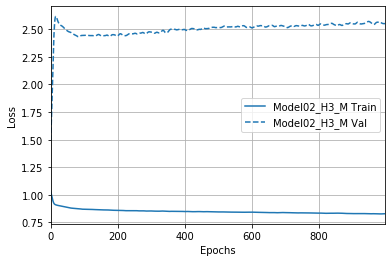

In [83]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(size_histories)

In [84]:
predictedResult = model.predict(test_X02, batch_size=1)

In [85]:
predictedResult

array([[0.41660985, 0.5070656 , 0.07632461],
       [0.5610228 , 0.3165062 , 0.12247102],
       [0.29222417, 0.63066715, 0.07710858],
       ...,
       [0.22255266, 0.41078693, 0.3666605 ],
       [0.27013195, 0.5307975 , 0.19907053],
       [0.39023516, 0.5594277 , 0.05033718]], dtype=float32)

In [86]:
ynewtrin = model.predict_classes(train_X02)
ynewtrin

array([1, 0, 1, ..., 1, 0, 2], dtype=int64)

Prob: Predicting only two classes instead of 3!

In [87]:
ynew = model.predict_classes(test_X02)
ynew

array([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 2, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,

In [88]:
test_y02 

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)